In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import warnings
from pathlib import Path
from time import time

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns

In [3]:
from src.analysis import pymc3_analysis as pmanal
from src.data_processing import achilles as achelp
from src.data_processing import common as dphelp
from src.exceptions import CacheDoesNotExistError
from src.io import cache_io
from src.io.models_io import models_dir
from src.loggers import logger, set_console_handler_level
from src.model_configuration import get_config_and_instantiate_model
from src.modeling import pymc3_sampling_api as pmapi
from src.models.speclet_eight import SpecletEight
from src.plot.color_pal import SeabornColor
from src.plot.plotnine_helpers import set_gg_theme
from src.project_config import read_project_configuration

In [4]:
notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)
set_console_handler_level(logging.INFO)

set_gg_theme()
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 847
np.random.seed(RANDOM_SEED)

MODELING_CONFIG = read_project_configuration().modeling
HDI_PROB = MODELING_CONFIG.highest_density_interval

In [5]:
sp8 = get_config_and_instantiate_model(
    models_dir() / MODELING_CONFIG.models_config,
    name="eight-default",
    root_cache_dir=models_dir(),
)

[11/02/21 14:03:35] INFO     Instantiating and configuring a       ]8;id=421692;file:///Users/admin/Lab_Projects/speclet/src/model_configuration.py\model_configuration.py]8;;\:238
                             speclet model from config.

                    INFO     Creating a new SpecletEight object.          ]8;id=43834;file:///Users/admin/Lab_Projects/speclet/src/models/speclet_eight.py\speclet_eight.py]8;;\:88

                    INFO     Adding new transformation.                  ]8;id=858134;file:///Users/admin/Lab_Projects/speclet/src/managers/data_managers.py\data_managers.py]8;;\:171

                    INFO     Adding new transformation.                  ]8;id=928753;file:///Users/admin/Lab_Projects/speclet/src/managers/data_managers.py\data_managers.py]8;;\:171

                    INFO     Adding new transformation.                  ]8;id=558677;file:///Users/admin/Lab_Projects/speclet/src/managers/data_managers.py\data_managers.py]8;;\:171

[11/02/21 14:03:42] INFO     Calling `model_specification()` method.     ]8;id=690483;file:///Users/admin/Lab_Projects/speclet/src/models/speclet_model.py\speclet_model.py]8;;\:148

                    INFO     Creating SpecletEight model.                ]8;id=634491;file:///Users/admin/Lab_Projects/speclet/src/models/speclet_eight.py\speclet_eight.py]8;;\:119

                    INFO     Getting data - reading from file.           ]8;id=275150;file:///Users/admin/Lab_Projects/speclet/src/managers/data_managers.py\data_managers.py]8;;\:126

                    WARNING  Dropping 0 sgRNA that map to multiple genes.     ]8;id=754217;file:///Users/admin/Lab_Projects/speclet/src/data_processing/achilles.py\achilles.py]8;;\:616

                    INFO     Adding 'rna_expr_gene_lineage' column. ]8;id=45610;file:///Users/admin/Lab_Projects/speclet/src/modeling/feature_engineering.py\feature_engineering.py]8;;\:73

[11/02/21 14:03:43] INFO     Number of data points: 1120                 ]8;id=321552;file:///Users/admin/Lab_Projects/speclet/src/models/speclet_eight.py\speclet_eight.py]8;;\:123

                    INFO     Number of sgRNA: 160                        ]8;id=771350;file:///Users/admin/Lab_Projects/speclet/src/models/speclet_eight.py\speclet_eight.py]8;;\:125

                    INFO     Number of genes: 101                        ]8;id=504035;file:///Users/admin/Lab_Projects/speclet/src/models/speclet_eight.py\speclet_eight.py]8;;\:126

                    INFO     Number of cell lines: 7                     ]8;id=518884;file:///Users/admin/Lab_Projects/speclet/src/models/speclet_eight.py\speclet_eight.py]8;;\:127

                    INFO     Number of lineages: 2                       ]8;id=675619;file:///Users/admin/Lab_Projects/speclet/src/models/speclet_eight.py\speclet_eight.py]8;;\:128

                    INFO     Creating shared variables.                  ]8;id=477948;file:///Users/admin/Lab_Projects/speclet/src/models/speclet_eight.py\speclet_eight.py]8;;\:131

[11/02/21 14:03:53] INFO     Non-centered parameterization for var 'h'.  ]8;id=759954;file:///Users/admin/Lab_Projects/speclet/src/models/speclet_eight.py\speclet_eight.py]8;;\:213

[11/02/21 14:03:57] INFO     Non-centered parameterization for var 'q'.  ]8;id=624406;file:///Users/admin/Lab_Projects/speclet/src/models/speclet_eight.py\speclet_eight.py]8;;\:213

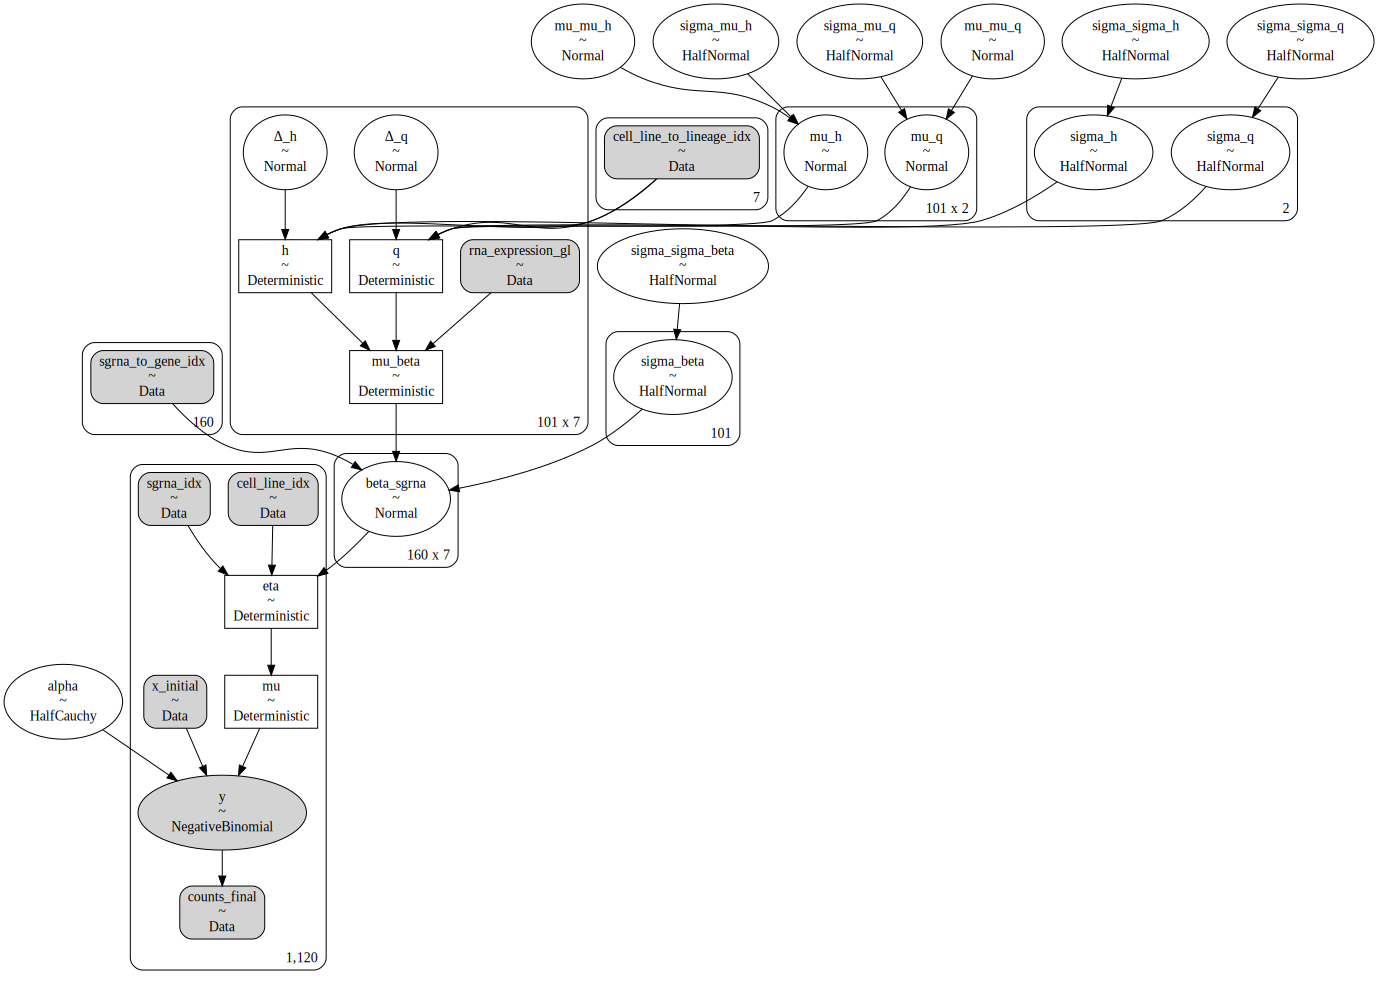

In [6]:
sp8.build_model()
pm.model_to_graphviz(sp8.model)

In [7]:
# sp8.mcmc_sample_model(
#     prior_pred_samples=-1,
#     random_seed=1,
#     sample_kwargs={"target_accept": 0.95},
#     ignore_cache=True,
# )

In [8]:
if sp8.cache_manager.mcmc_cache_exists():
    sp8_trace = sp8.load_mcmc_cache()
else:
    raise CacheDoesNotExistError(sp8.cache_manager.mcmc_cache_delegate.cache_dir)

[11/02/21 14:04:14] INFO     ArvizCacheManager: MCMC cache exists.      ]8;id=605867;file:///Users/admin/Lab_Projects/speclet/src/managers/cache_managers.py\cache_managers.py]8;;\:119

                    INFO     ArvizCacheManager: MCMC cache exists.      ]8;id=307425;file:///Users/admin/Lab_Projects/speclet/src/managers/cache_managers.py\cache_managers.py]8;;\:119

                    INFO     ArvizCacheManager: MCMC cache exists.      ]8;id=18583;file:///Users/admin/Lab_Projects/speclet/src/managers/cache_managers.py\cache_managers.py]8;;\:119

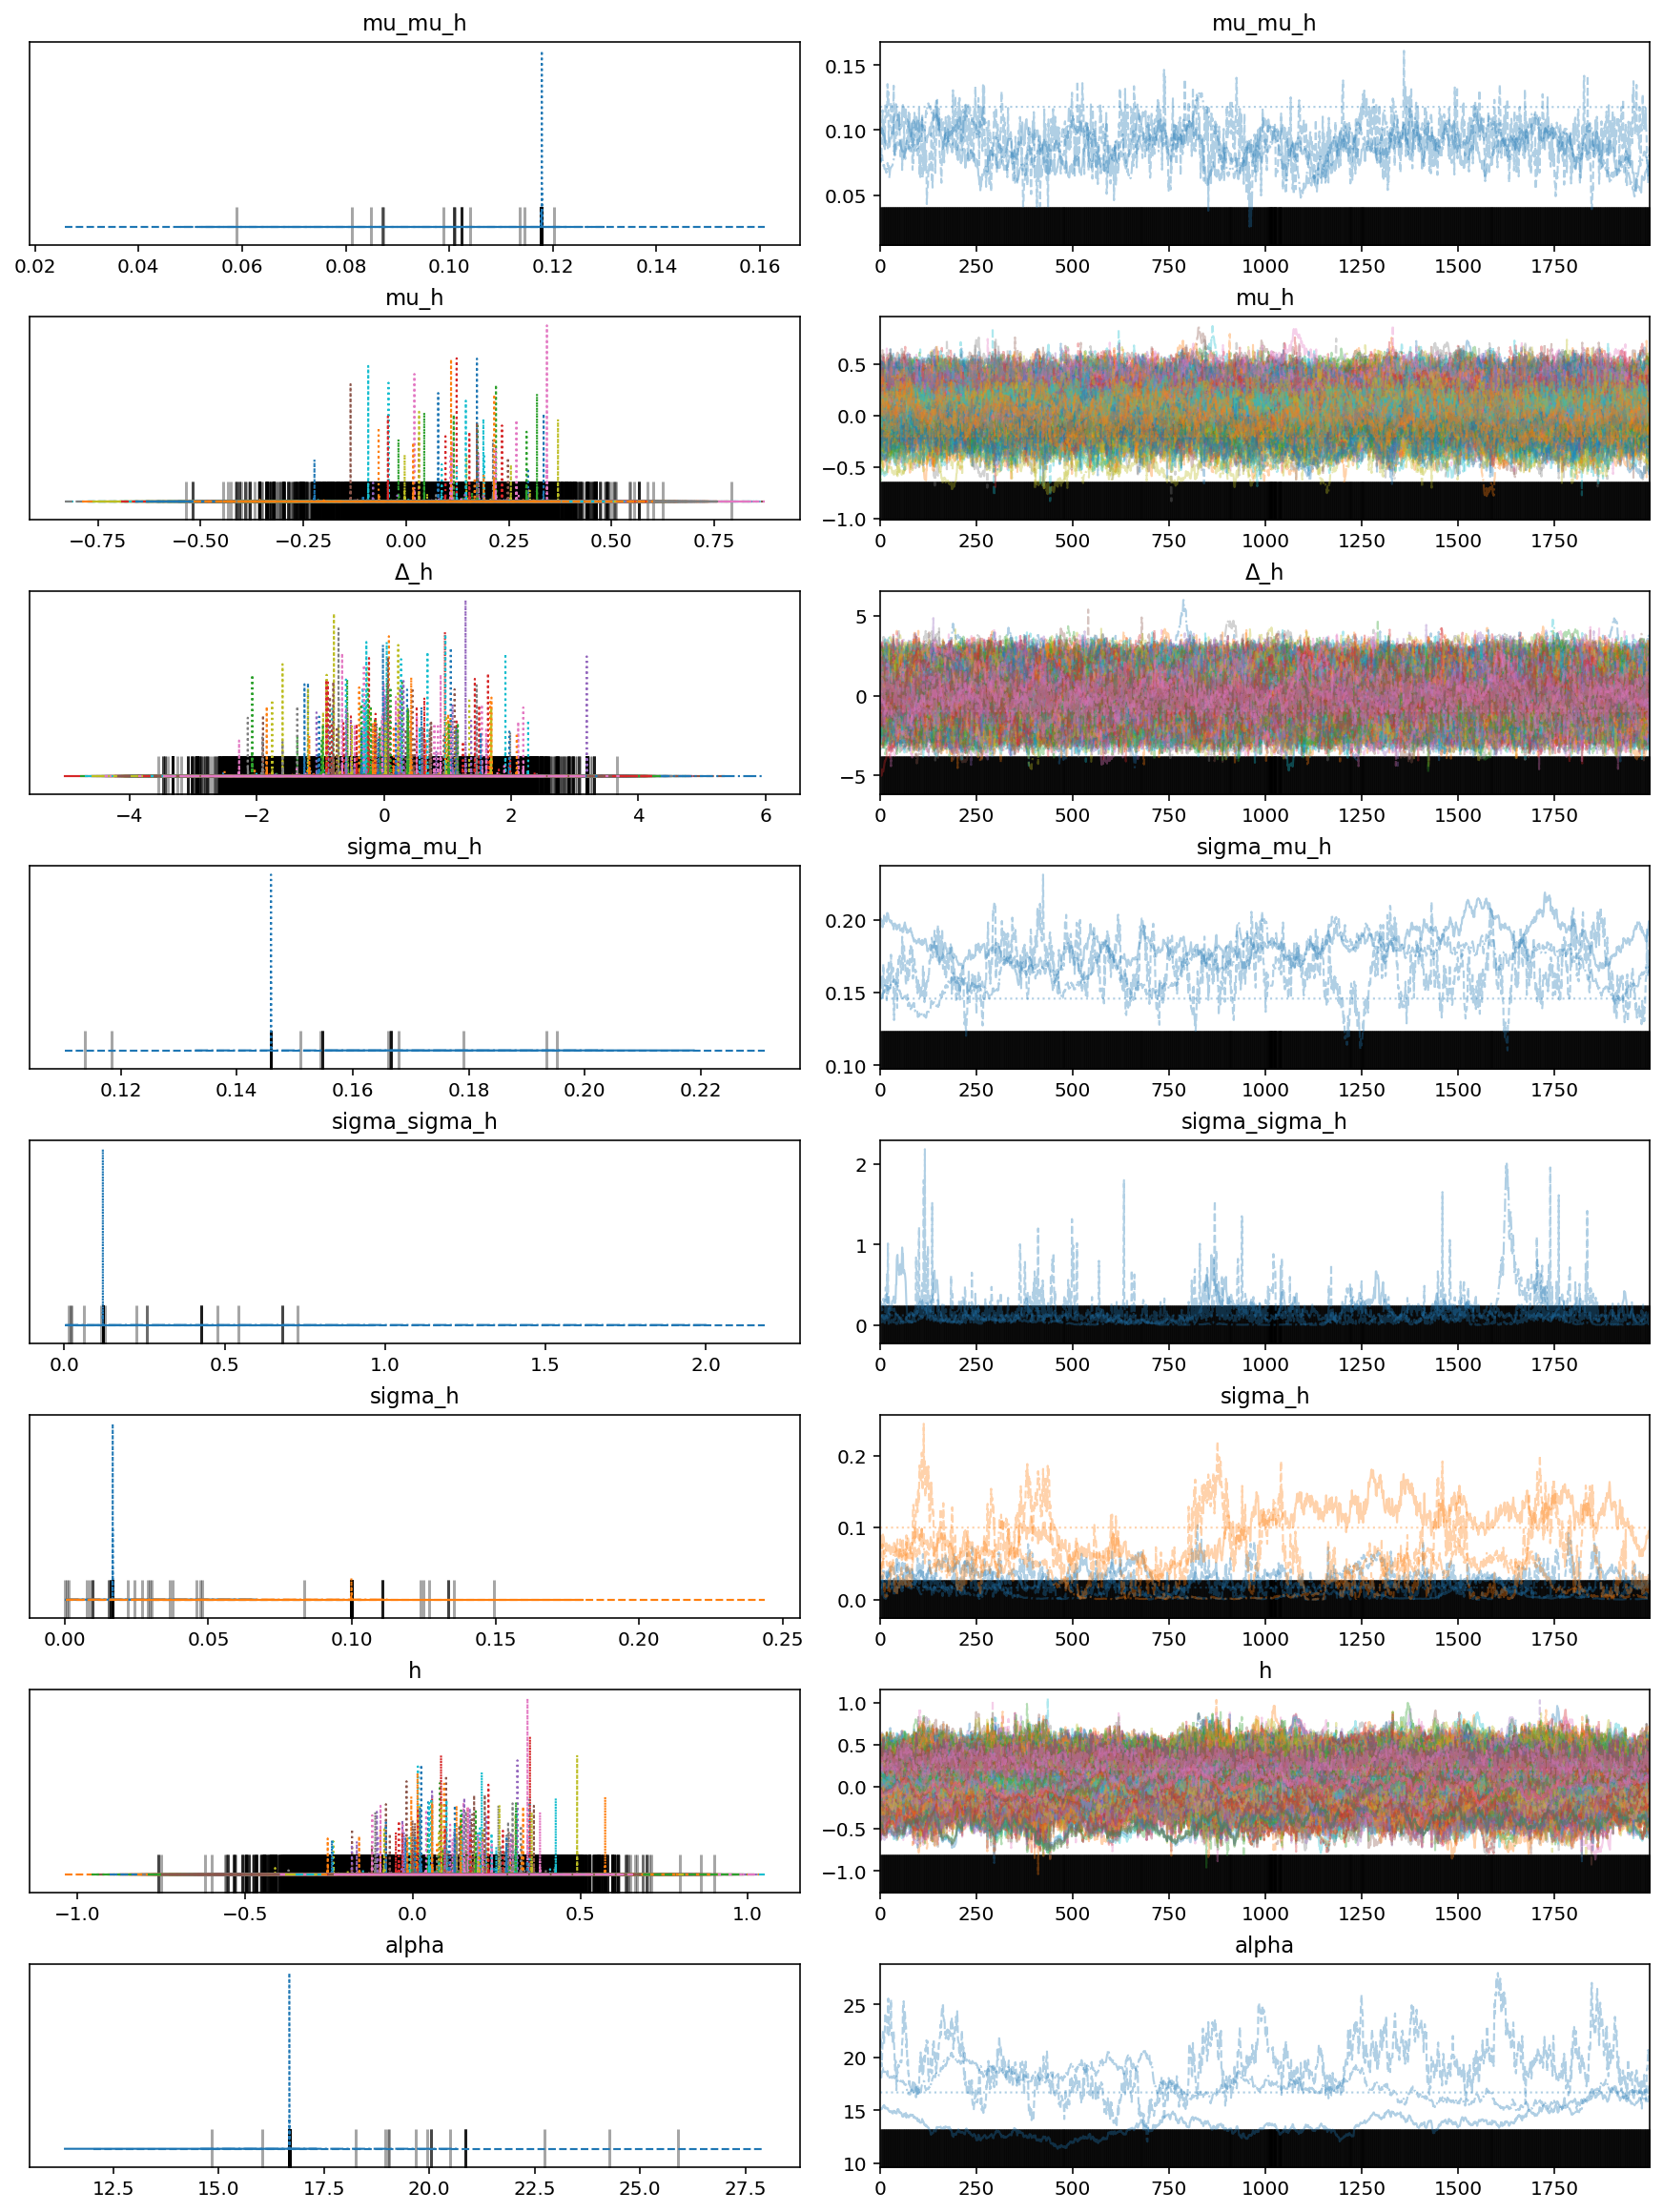

In [9]:
az.plot_trace(sp8_trace, var_names=["h"], filter_vars="like")
plt.show()

sampled 4 chains with (unknown) tuning steps and 2,000 draws
num. divergences: 0, 2000, 20, 0
percent divergences: 0.0, 100.0, 1.0, 0.0
BFMI: 0.212, 2.047, 0.15, 0.441
avg. step size: 0.0, 0.0, 0.003, 0.001


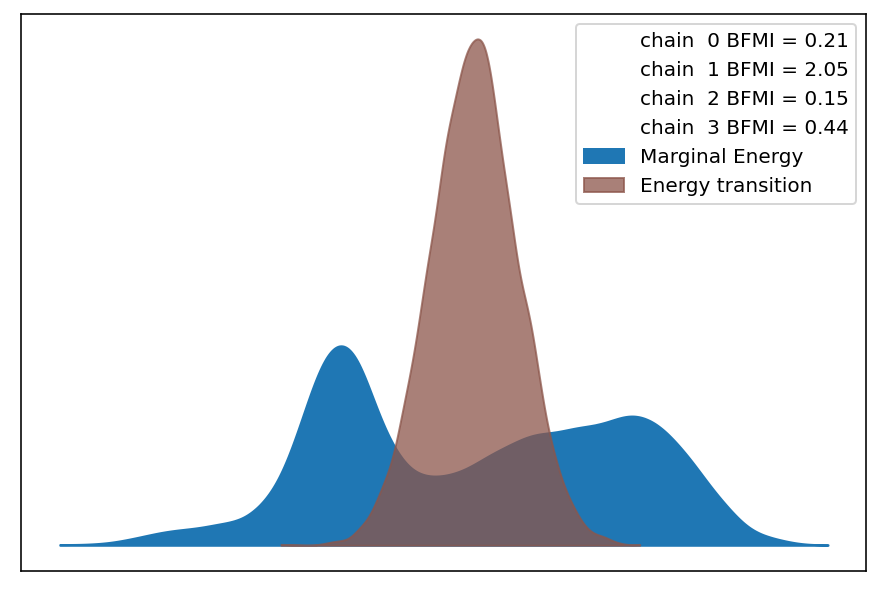

MCMCDescription(created=None, duration=None, n_chains=4, n_tuning_steps=None, n_draws=2000, n_divergences=[0, 2000, 20, 0], pct_divergences=[0.0, 100.0, 1.0, 0.0], bfmi=[0.21218315035784435, 2.0467157284382123, 0.14999682959225488, 0.4413881989108723], avg_step_size=[0.00023128229087214177, 0.0004056219067879502, 0.003411216942234889, 0.000717120194474947])

In [10]:
pmanal.describe_mcmc(sp8_trace)

---

In [ ]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

In [ ]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m